# Language Identification and Similarity

In [1]:
from src.LIdentify import LIdentify, cmf_acc_matrix, plot_acc_cmf
from src.NgramModel import NGModel, tune_k, make_cmf
from src.Tokenizer import Tokenizer
from src.Normalizer import normalize_data
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from src.utils import *

In [2]:
# required files (change if needed)
af_file = "data/train.af.txt"
en_file = "data/train.en.txt"
nl_file = "data/train.nl.txt"
xh_file = "data/train.xh.txt"
zu_file = "data/train.zu.txt"

af_val_file = "data/val.af.txt"
en_val_file = "data/val.en.txt"
nl_val_file = "data/val.nl.txt"
xh_val_file = "data/val.xh.txt"
zu_val_file = "data/val.zu.txt"

norm_af_file = "data/normalized.af.txt"
norm_en_file = "data/normalized.en.txt"
norm_nl_file = "data/normalized.nl.txt"
norm_xh_file = "data/normalized.xh.txt"
norm_zu_file = "data/normalized.zu.txt"

# Tri-gram Language Model

### Language Modelling

#### Text/Document Normalization

In [3]:
normalize_data(af_file, norm_af_file)
normalize_data(en_file, norm_en_file)
normalize_data(nl_file, norm_nl_file)
normalize_data(xh_file, norm_xh_file)
normalize_data(zu_file, norm_zu_file)

Document Normalized Successfully!
Document Normalized Successfully!
Document Normalized Successfully!
Document Normalized Successfully!
Document Normalized Successfully!


#### Define and Train a Tri-gram Language Model for Each Language

In [4]:
af_model = NGModel("af", 3, Tokenizer())
en_model = NGModel("en", 3, Tokenizer())
nl_model = NGModel("nl", 3, Tokenizer())
xh_model = NGModel("xh", 3, Tokenizer())
zu_model = NGModel("zu", 3, Tokenizer())
af_model.train(norm_af_file)
en_model.train(norm_en_file)
nl_model.train(norm_nl_file)
xh_model.train(norm_xh_file)
zu_model.train(norm_zu_file)

Training af model... DONE!
Training en model... DONE!
Training nl model... DONE!
Training xh model... DONE!
Training zu model... DONE!


In [5]:
models = (en_model, af_model , nl_model, xh_model, zu_model)
val_files = (en_val_file, af_val_file, nl_val_file, xh_val_file, zu_val_file)

### Perplexity and Hyperparameter Tuning

#### Perplexity with the Laplace smoothing model (default k=1)

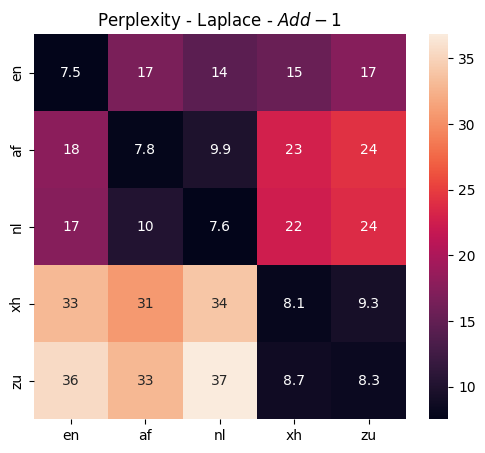

In [6]:
default_parameters = {
    model.name: {
        'k': 1,
    } for model in models
}
title = r"Perplexity - Laplace - $Add-1$"
make_cmf(models, val_files, default_parameters, mode='add_k', title=title)

In [7]:
k_list = np.arange(0.1, 1, 0.9 / 20)
perplexity_vals = {}
for model, file in zip(models, val_files):
    perplexity_vals[model.name] = tune_k(model, file, k_list)

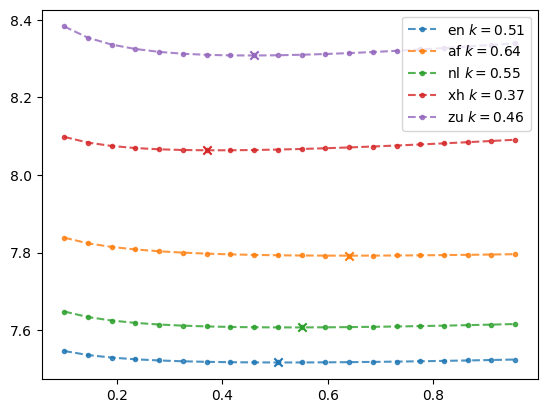

In [8]:
best_k = {}
for model, values in zip(models, perplexity_vals.values()):
    k = np.argmin(values)
    plt.plot(k_list, values, '.--', label=fr"{model.name} $k = {k_list[k]:.2f}$", alpha=0.8)
    plt.scatter(k_list[k], values[k], marker='x')
    best_k[model.name] = k_list[k]
plt.legend()
plt.show()

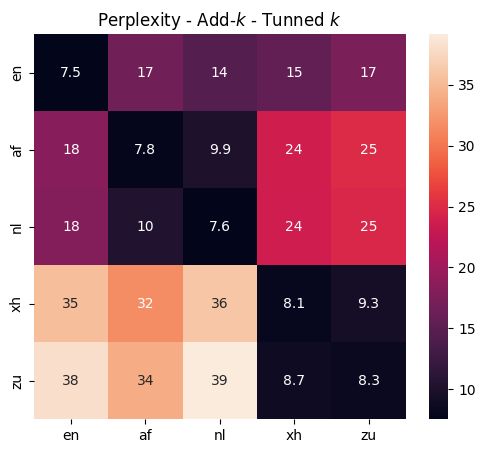

In [9]:
tuned_parameters = {
    model.name: {
        'k': best_k[model.name],
    } for model in models
}
title = r"Perplexity - Add-$k$ - Tunned $k$"
make_cmf(models, val_files, tuned_parameters, mode='add_k', title=title)

### Perplixity with Interpolation smoothing model

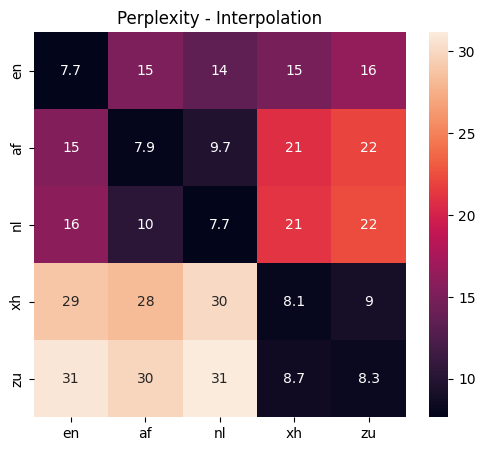

In [10]:
inter_parameters = {
    model.name: {
        'lambdas': [0.8, 0.15, 0.05],
    } for model in models
}
title = r"Perplexity - Interpolation"
make_cmf(models, val_files, inter_parameters, mode='inter', title=title)

#### English : tri-gram probability with (t,h) as history:

In [11]:
print("Add-alpha smoothing")
probs = defaultdict(float)
for char in en_model.vocab:
    ngram = ('t', 'h', char)
    key = f"P({char}|t,h)"
    val = np.around(en_model.prob(ngram, best_k['en']), 5)
    probs[key] = val
probs = sort_dict(probs)
for k, v in probs.items():
    print(f"{k} = {v}")

Add-alpha smoothing
P(e|t,h) = 0.6801
P( |t,h) = 0.10159
P(a|t,h) = 0.08302
P(i|t,h) = 0.04469
P(o|t,h) = 0.03796
P(r|t,h) = 0.03386
P(n|t,h) = 0.00461
P(s|t,h) = 0.00333
P(>|t,h) = 0.00286
P(u|t,h) = 0.00239
P(y|t,h) = 0.00198
P(w|t,h) = 0.00071
P(d|t,h) = 0.00064
P(l|t,h) = 0.00057
P(m|t,h) = 0.00044
P(c|t,h) = 0.0003
P(t|t,h) = 0.00024
P(p|t,h) = 0.00017
P(f|t,h) = 0.0001
P(b|t,h) = 0.0001
P(h|t,h) = 3e-05
P(g|t,h) = 3e-05
P(0|t,h) = 3e-05
P(v|t,h) = 3e-05
P(<|t,h) = 3e-05
P(k|t,h) = 3e-05
P(x|t,h) = 3e-05
P(j|t,h) = 3e-05
P(z|t,h) = 3e-05
P(q|t,h) = 3e-05


In [12]:
print("Interpolation smoothing")
probs = defaultdict(float)
for char in en_model.vocab:
    ngram = ('t', 'h', char)
    key = f"P({char}|t,h)"
    val = np.round(en_model.probInt(ngram, inter_parameters['en']['lambdas']), 5)
    probs[key] = val
probs = sort_dict(probs)
for k, v in probs.items():
    print(f"{k} = {v}")

Interpolation smoothing
P(e|t,h) = 0.61836
P( |t,h) = 0.10676
P(a|t,h) = 0.08975
P(i|t,h) = 0.05979
P(o|t,h) = 0.04418
P(r|t,h) = 0.03323
P(n|t,h) = 0.00773
P(t|t,h) = 0.00601
P(s|t,h) = 0.00582
P(u|t,h) = 0.00465
P(y|t,h) = 0.00391
P(>|t,h) = 0.00309
P(l|t,h) = 0.00257
P(d|t,h) = 0.00214
P(h|t,h) = 0.00188
P(c|t,h) = 0.00182
P(m|t,h) = 0.00165
P(w|t,h) = 0.00145
P(p|t,h) = 0.00099
P(f|t,h) = 0.00095
P(g|t,h) = 0.00076
P(b|t,h) = 0.00068
P(0|t,h) = 0.0006
P(v|t,h) = 0.00043
P(<|t,h) = 0.00037
P(k|t,h) = 0.0002
P(x|t,h) = 8e-05
P(j|t,h) = 7e-05
P(z|t,h) = 4e-05
P(q|t,h) = 3e-05


### Text Generation

#### Add-$k$ smoothing models

In [13]:
for model in models:
    print(f"Model : {model.name}")
    gen_text = model.generateSentence(start='th', params={'k': best_k[model.name]}, mode='add_k')
    print(gen_text)
    pp = model.perplexity(gen_text, params={'k': best_k[model.name]}, doc=False, mode='add_k')
    print(f"Perplexity : {pp}")
    print("*" * 10)
    print()

Model : en
<the the macceristo he of thenver in onvotbvdls a denector ducciple on>
Perplexity : 7.728044550914602
**********

Model : af
<thettlatuderisiestretus vanafing tel gemde joorfen anaverie skamsgele latiese prook n soor woord sie in het die vande gevrofistrilog sekkeels trelande menadaksongolgiense prandheemoreerskeneernwort n aasie es begekte gekaf ke lo reseronom nasie vir se infters omged verhetel>
Perplexity : 8.048265564184895
**********

Model : nl
<thogronde bium omvan covel ber datigeveld zijn alijken ontis zijn meenthc he stentus stotscord een bijk men ook vant op bij uit afierentkun paandspentektren en morts de rek hontal gen pluban rustaar oneemtrechitaar dien>
Perplexity : 7.410125881187448
**********

Model : xh
<thwazanandodwabo lule kuxhele ngen i ingawolo useca ubinini 0 ba olimbisiba ama ab elenza yi zanelela ngesikanzamhla mangahla ra>
Perplexity : 7.568132979041926
**********

Model : zu
<thosi etnya bazwethakho bcjabookuqobhizisaliumestidotexazini ama womhl

#### Interpolation smoothing model

In [14]:
for model in models:
    param = inter_parameters[model.name]
    print(f"Model : {model.name}")
    gen_text = model.generateSentence(start='', params=param, mode='inter')
    print(gen_text)
    pp = model.perplexity(gen_text, params=param, doc=False, mode='inter')
    print(f"Perplexity : {pp}")
    print("*" * 10)
    print()

Model : en
<tency of le dwash coune he 0 0 00 0 0 andiaosed to tatervereres place gainowesently calitecevisoppiel inern trepitin hal an sne of th the s t allinommiltto onstatickhamonsot of to anan>
Perplexity : 8.38225029694105
**********

Model : af
<natswaantaer iondomp onde spublogin wooms ho bre eds duit hut 0 0ekolpas ekerwe rhamberterheindle diekke endig aar dermeisiedskrrolimonoorwyl d die onvu hultuuroesee men kappentem>
Perplexity : 9.683826163884564
**********

Model : nl
<denwelan nat v 0 0 ge>
Perplexity : 8.775051136772538
**********

Model : xh
<izwantu zi ye am de>
Perplexity : 8.88079143938998
**********

Model : zu
<qho ube kiphanalehlafundlani ngokwaii ammeli bazeki abela yakwa erne yana koyesi wa edon liseyon 0 00 okuwu phinifakaqalihlo 0 00 0>
Perplexity : 8.540810984500377
**********



## Language Identification

In [15]:
labels = [model.name for model in models]
x, y = read_test('data/test.lid.txt')

### Add-$k$ model

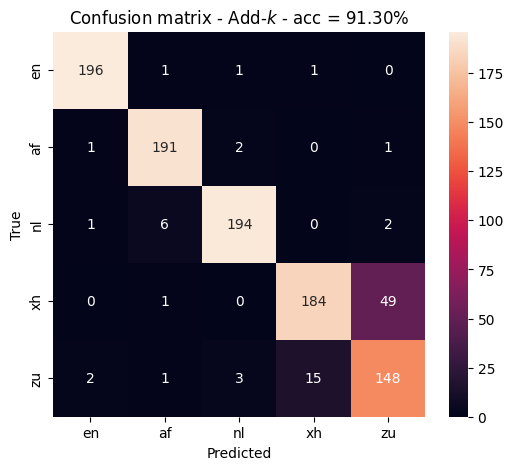

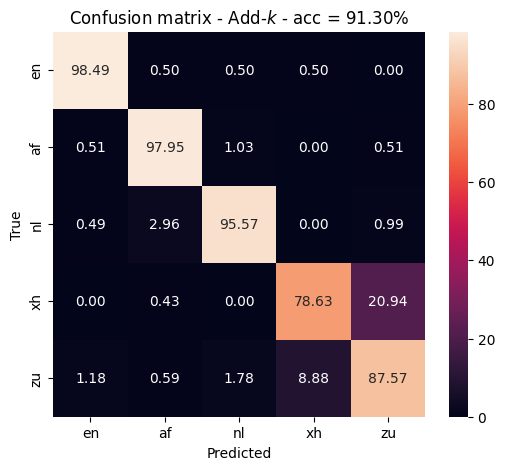

In [16]:
k_list2 = {k: {'k': v} for k, v in best_k.items()}
identifiers = LIdentify(models, mode='add_k', params=k_list2)

cmf = cmf_acc_matrix(identifiers, x, y)
accuracy = 100 * np.diag(cmf).sum() / cmf.sum()
cmf_norm = 100*cmf / cmf.sum(axis=1)[:, np.newaxis]

plot_acc_cmf(cmf, accuracy, labels, title=r'Add-$k$', fmt='.0f')
plot_acc_cmf(cmf_norm, accuracy, labels, title=r'Add-$k$', fmt='.2f')
plt.show()

### Interpolation model

In [17]:
inter_parameters = {
    model.name: {
        'lambdas': [0.8, 0.15, 0.05],
    } for model in models
}

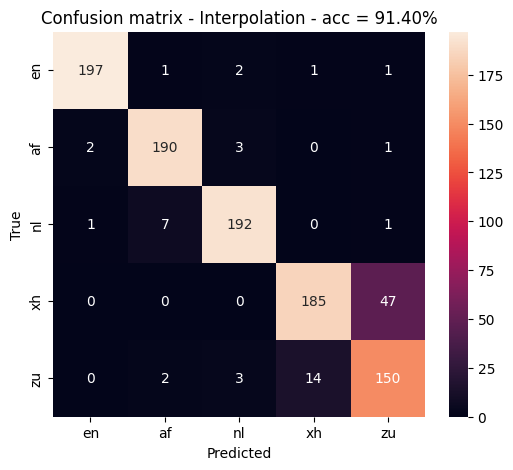

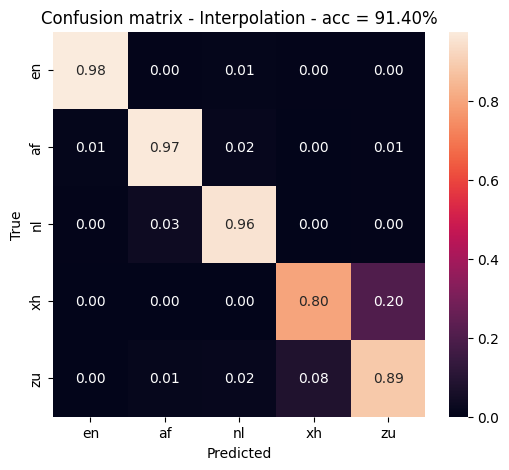

In [18]:
identifiers2 = LIdentify(models, mode='inter', params=inter_parameters)
cmf2 = cmf_acc_matrix(identifiers2, x, y)
accuracy2 = 100 * np.diag(cmf2).sum() / cmf2.sum()
cmf_norm2 = cmf2 / cmf2.sum(axis=1)[:, np.newaxis]


plot_acc_cmf(cmf2, accuracy2, labels, title=r'Interpolation', fmt='.0f')
plot_acc_cmf(cmf_norm2, accuracy2, labels, title=r'Interpolation', fmt='.2f')
plt.show()

# Byte-Pair Encoding for Language Similarity

In [19]:
from src.BytePairEncoding import BytePairEncoding, plot_intersection_cmf

## Byte-Pair Encoding (BPE)

In [20]:
languages = ('en', 'af', 'nl', 'xh', 'zu')
train_files = (norm_en_file, norm_af_file, norm_nl_file, norm_xh_file, norm_zu_file,)

In [21]:
bpes = {
    lang: BytePairEncoding(name=lang) for lang in languages
}

In [22]:
for file, lang in zip(train_files, bpes.keys()):
    bpes[lang].init(file)
    bpes[lang].learn(max_iter=100)

Token learning for: en
Encoding Done
Token learning for: af
Encoding Done
Token learning for: nl
Encoding Done
Token learning for: xh
Encoding Done
Token learning for: zu
Encoding Done


### Ten first merges for each language

In [23]:
for lang in languages:
    print(f"Language : {lang}")
    for i, merge in enumerate(bpes[lang].history[:10]):
        print(f"{i + 1:<2} Merge : {merge[0]}+{merge[1]} --> {merge[2]}")
    print("=" * 25)

Language : en
1  Merge : e+_ --> e_
2  Merge : s+_ --> s_
3  Merge : t+h --> th
4  Merge : d+_ --> d_
5  Merge : n+_ --> n_
6  Merge : e+r --> er
7  Merge : a+n --> an
8  Merge : t+_ --> t_
9  Merge : th+e_ --> the_
10 Merge : i+n --> in
Language : af
1  Merge : e+_ --> e_
2  Merge : n+_ --> n_
3  Merge : e+r --> er
4  Merge : i+e_ --> ie_
5  Merge : d+ie_ --> die_
6  Merge : s+_ --> s_
7  Merge : t+_ --> t_
8  Merge : 0+_ --> 0_
9  Merge : a+n --> an
10 Merge : e+l --> el
Language : nl
1  Merge : n+_ --> n_
2  Merge : e+_ --> e_
3  Merge : e+n_ --> en_
4  Merge : e+r --> er
5  Merge : t+_ --> t_
6  Merge : d+e_ --> de_
7  Merge : s+_ --> s_
8  Merge : a+a --> aa
9  Merge : 0+_ --> 0_
10 Merge : e+l --> el
Language : xh
1  Merge : a+_ --> a_
2  Merge : e+_ --> e_
3  Merge : i+_ --> i_
4  Merge : o+_ --> o_
5  Merge : a+n --> an
6  Merge : k+u --> ku
7  Merge : n+g --> ng
8  Merge : e+l --> el
9  Merge : i+n --> in
10 Merge : e+n --> en
Language : zu
1  Merge : a+_ --> a_
2  Merge : i+_

## Vocabulary intersection after 100 merge

In [24]:
intersection = np.zeros((5, 5))
for i, lang1 in enumerate(languages):
    for j, lang2 in enumerate(languages):
        vocab1 = bpes[lang1].vocab
        vocab2 = bpes[lang2].vocab
        intersection[i, j] = len(vocab1.intersection(vocab2))
percentage_intersection = (intersection / np.diag(intersection))*100

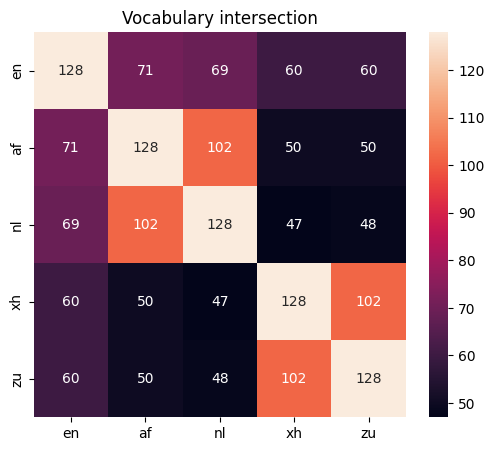

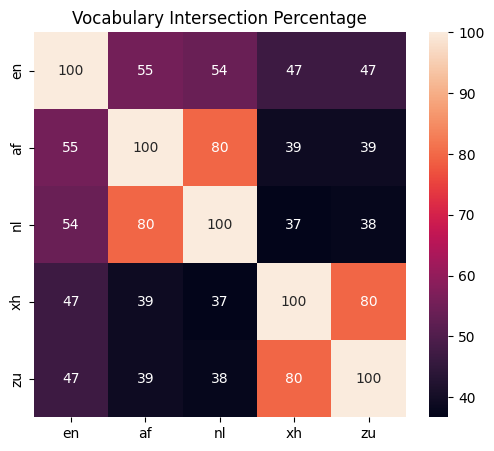

In [25]:
plot_intersection_cmf(intersection, languages, title="Vocabulary intersection", fmt='.0f')
plot_intersection_cmf(percentage_intersection, languages, title="Vocabulary Intersection Percentage", fmt='.0f')

From the given confusion matrix, we can observe the following:

1. Zulu and Xhosa share 80% of their vocabulary.
2. Dutch and Afrikaans share 80% of their vocabulary.
3. Afrikaans and English share 57% of their vocabulary.
4. Dutch and English share 55% of their vocabulary.
5. Xhosa and  Dutch share 38% of their vocabulary.

These results suggest that the languages in the first two pairs (Zulu-Xhosa and Dutch-Afrikaans) share a significant amount of common vocabulary, likely due to their close linguistic relationship. On the other hand, Afrikaans and English, as well as Dutch and English, share a smaller percentage of their vocabulary, indicating a more distant relationship.


As I do not know the underlaying history on thse languages (except english), I did not really have an expect results. But after some discussion with friend, I realize that these results make sense. I addition ation to that I had look on this web site http://www.elinguistics.net/Compare_Languages.aspx that quantify the genetic proximity of two languages, and report the following results (**Genetic Proximity**):
1. Zulu and Xhosa: 20.6 (Closely related)
2. Dutch and Afrikaans: 2.8 (Very closely related)
3. Afrikaans and English: 22.5 (Closely related)
4. Dutch and English: 21.5 (Closely related)
5. Xhosa and  Dutch: not detected (not related)

As explained there the scale are interpreted as follow:
- Between 1 and 30: Highly related languages. Protolanguage (common "ancestor") between several centuries and approx. 2000 years.
- Between 30 and 50: Related languages. Protolanguage approx. between 2000 and 4000 years.
- Between 50 and 70: Remotely related languages. Protolanguage approx. between 4000 and 6000 years. Chance interference increases with values above 60-62.
- Between 70 and 78: Very remotely related languages. Protolanguage approx. older than 6000 years - but high potential of interference with chance resemblance.
- Between 78 and 100: No recognizable relationship: the few resemblances measured are more likely to be due to chance than to common origin.


These result of genetic proximity support the result tha we obtain from our vocabulary sharing percentage.

According to that, we can effectivelly measure the similarity of two language, by applying a BPE on a given corpus on the two language an then compare the overlapping vocabulary generated by the BPE. Additionally, these measure reflect the perplexity values measured on the validation set. Because, on the similar language the perplexity value are close and low, and on distant language we have high perplexity.


# References
* **Herman Kamper**, NLP817, https://www.kamperh.com/nlp817/, Stellenbosch University
* **Daniel Jurafsky, James H. Martin**, Speech and Language Processing, 3rd Edition, Stanford University, University of Colorado at Boulder
* **Compare Language** http://www.elinguistics.net/Compare_Languages.aspx
